# Load and prepare Data

Initially, we import the gold standard into a dataframe and seperate the annotations provided by human annotators from the potenitally antisemetic tweets. The tweets will undergo annotation by the LLM later in our experiment, while the human annotations will provide the benchmark against which the LLM's annotations will be evaluated.

In [14]:
import pandas as pd
path = "../input/data/Updated_dataset_with_full_text/Updated_dataset_with_full_text.csv"
df = pd.read_csv(path)
df.head(10)

,TweetID,Username,CreateDate,Biased,Keyword,Text
0,1232258532273090560,amit2nirvana,2020-02-25 10:58:23+00:00,0,Israel,The last 24 hours in Israel: https://t.co/0YNw...
1,1224025761092448257,NinjaAlex420,2020-02-02 17:44:17+00:00,0,Israel,@stranahan KnowMoreNews isn't confident enough...
2,1242382710561107969,SevenShepherd,2020-03-24 09:28:15+00:00,0,Israel,"""[Even] an heritage unto Israel his servant: f..."
3,1224677205306818561,MGSheikh8,2020-02-04 12:52:53+00:00,0,Israel,Opinion: No One in Israel Knew They Were Commi...
4,1214278369338109953,elianebis1,2020-01-06 20:11:38+00:00,0,Israel,https://t.co/LTB0zidzM9 When #TheCloudOfGod ap...
5,1239732209872928768,RabbiShmuley,2020-03-17 01:56:06+00:00,0,Israel,Smokers appear to be at higher risk from coron...
6,1230234863438983168,BlacklistedNews,2020-02-19 20:57:02+00:00,0,Israel,CBS News: 'How Jewish American Pedophiles Hide...
7,1246631594191990799,MNZ_Watchman,2020-04-05 02:51:48+00:00,0,Israel,@bismofunyunsss @jlineberry @BernieSanders How...
8,1222609422238617600,Jan_lindsay,2020-01-29 19:56:15+00:00,1,Israel,@JoAnn54819331 @JB62154 @SexCounseling @Robert...
9,1232130327059091456,PeterCurtin4,2020-02-25 02:28:56+00:00,0,Israel,Stunning how gratuitously and galactically stu...


In [15]:
import re

filtered_df = df[~df["Text"].str.contains(r'https?://\S+', case=False, regex=True)]

print(df.shape)
print(filtered_df.shape)

# Resetting the indices
filtered_df = filtered_df.reset_index(drop=True)

filtered_df["Keyword"].value_counts(normalize=True)

(6941, 6)
(3235, 6)


Jews       0.691808
Israel     0.187326
ZioNazi    0.076352
Kikes      0.044513
Name: Keyword, dtype: float64

## Annotate Data

In [16]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.chat_models import ChatOllama

#https://anakin.ai/blog/dolphin-2-5-mixtral-8x7b-uncensored-mistral/
chat_model = ChatOllama(
    model="dolphin-mistral", 
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
)

In [17]:
from langchain.schema import HumanMessage

messages = [HumanMessage(content="How are you")]
response = chat_model(messages)

Hello! I am an Artificially Intelligent being, designed to interact and support users with information or assistance. I'm always happy to help and provide a pleasant conversation experience. How can I assist you today?

In [18]:
prompt_path = '../input/prompts/prompt_7.txt'

with open(prompt_path, 'r') as file:
    prompt = file.read()

prompt = prompt.replace('\n', ' ')
prompt

'<|im_start|>system You are Dolphin, an expert on Antisemitism working as a Tweet-Annotator, tasked with checking if tweets are antisemitic or not. You use the following definition of antisemitism: Antisemitism is a certain perception of Jews, which may be expressed as hatred toward Jews. Rhetorical and physical manifestations of antisemitism are directed toward Jewish or non-Jewish individuals or their property, toward Jewish community institutions and religious facilities. Antisemitism might include the targeting of the state of Israel, conceived as a Jewish collectivity. However, criticism of Israel similar to that leveled against any other country cannot be regarded as antisemitic. Antisemitism frequently charges Jews with conspiring to harm humanity, and it is often used to blame Jews for “why things go wrong.” Contemporary examples of antisemitism include: 1. Comparing Israel or Jews to the south african apartheid regime. 2.Questioning Israel\'s legitimacy, history, existence or 

In [19]:
import numpy as np

# add predictions column if it doesn't exist
if "Prediction" not in filtered_df.columns:
    filtered_df["Prediction"] = np.nan

for index, row in filtered_df.iterrows():
    print(f"Row {index}: [{row['Biased']}]", end=" ")
    
    if pd.isna(row["Prediction"]):
        messages = [HumanMessage(content= prompt + row["Text"] + " <|im_end|><|im_start|>assistant")]
        answer = str(chat_model(messages))
        filtered_df.at[index, "Prediction"] = answer
        print("")
        
    else:
        print("Row skipped")

Row 0: [0]  0. This tweet shares a quote from the Bible (specifically Psalm 136) and uses it as an example of poetry. While there are no explicit antisemitic elements present in this tweet, it is not expressing hatred or rhetorical manifestations against Jews or Israel, which would be required for classification as antisemitic according to the provided definition. The quote is a positive reference to Israel within the context of faith and religion.
Row 1: [1] 1. This tweet can be considered antisemitic because it contains a false accusation that Israel is stealing land and invading another country (Palestine). While Palestine is indeed in conflict with Israel, this statement oversimplifies and distorts the complex historical background of this issue. Moreover, comparing Israel's actions to Nazi Germany's invasion of Poland inserts an antisemitic undertone into the tweet. This kind of rhetoric often seeks to blame Jews for wrongdoing committed by a nation state or group, which falls und

In [10]:
from pathlib import Path  
filepath = Path("../output/annotations/experiment_mistral_prompt_7.csv")

# Save annotations to csv
#filtered_df.to_csv(filepath)

# Data Cleaning

As the model did not adhere to the specified answer-format, its predictions need to be converted to booleans. 


In [24]:
import pandas as pd
df = pd.read_csv(filepath)

As we can see, there are most of the answers are actually correctly formatted as booleans, while lots of others are variations of the same sentences. Accordingly, we should be able to standartize the models output manually. To do so, let's:
- remove prefixes "content=" and "[INST]"
- convert text to lowercase
- remove punctuation
- remove leading and trailing whitespaces


In [25]:
import string

# Remove 'content=' from the beginning of each string
df["Prediction"] = df['Prediction'].str.replace('^content=','', regex=True)

# Remove newlines
df['Prediction'] = df['Prediction'].str.replace('\n', '', regex=False)

# Remove punctuation
df["Prediction"] = df['Prediction'].str.replace('[^\w\s]','', regex=True)

# remove leading and trailing whitespaces
df["Prediction"] = df['Prediction'].str.strip()

Now, we can extract the first character of the answer, which should contain the models classification as a Boolean. 

In [26]:
df["Prediction_to_Boolean"] = df["Prediction"]

# Replace all text containing the string 1 or 0 as a first character with 1 or 0
df['Prediction_to_Boolean'] = df['Prediction_to_Boolean'].apply(lambda x: x[0] if x[0] in ['0', '1'] else x)

What's left now, are mostly answers given as text without the classification as boolean. We can use a rules-based approach to convert them into booleans. 

In [28]:
# Replace all answers containing the phrase "is not antisemitic" or "the tweet is antisemitic" with the corresponding booleans
negative_phrases = ["The answer for this tweet is 0","my answer for this specific case would be 0", "provide my judgment based on this broader interpretationnn0", "I would classify this tweet asn0","I classify this tweet as 0","I would classify this particular tweet as a 0 ","is not classified as antisemitic","can be considered not antisemitic","tweet does not explicitly show signs of antisemitism","response would be 0","0 classification","I would classify this tweet as followsnn0","into the category of antisemitic content 0","can be classified as 0","I classify this tweet as a 0","0 not antisemitic","antisemitic 0","my answer isnn0","this would be classified as 0", "I would classify this tweet as not antisemitic","my answer for this tweet would be 0","my answer is 0","answer to this specific tweet is 0","0 Not Antisemitic","tweet appears to be nonantisemitic 0","Answer 0","my answer would benn0","tweet does not fall under the category of antisemitic","tweet does not fit the definition of antisemitism", "should be classified as 0", "does not seem to be explicitly antisemitic 0", "Annotation 0 ", "tweet does not appear to be antisemitic", "tweet does not directly express hatred toward Jews","tweet does not express hatred towards Jews", "does not appear to contain any antisemitic language","is not an expression of hatred towards Jews", "This is not antisemitic","cannot be classified as antisemitic", "Therefore this tweet would be categorized as 0", "conclude that this tweet is most likely NOT antisemitic", "I would classify this tweet as 0 ", "I would classify this tweet as a 0","this tweet does not appear to be antisemitic", "I would rate this tweet as 0", "this tweet is not inherently antisemitic", "I would classify this tweet as not being antisemiti", "I would classify it as not explicitly antisemitic", "I would classify it as a 0", "is not an antisemitic tweet", "tweet is not antisemitic", "can be considered antisemitic", "tweet does not meet the criteria for an antisemitic statement", "tweet does not directly contain any of the specific examples", ]
positive_phrases = ["can be considered as potentially antisemitic 1","tweet can be classified under the umbrella of antisemitic content","it can be antisemitic based on this definition","exhibit clear antisemitic content","my answer is 1","can be classified as 1","1 antisemitic","tweet could be classified as potentially antisemitic","I would classify this tweet as antisemitic 1","I classify this tweet as n1","tweet is classified as antisemitic 1","This tweet is antisemitic","can be considered as antisemitic", "answer for this tweet is 1", "should be classified as antisemitic","The classification of this particular tweet as antisemitic is straightforward", "I would classify this as a 1", "tweet is classified as 1", "classify it as an antisemitic tweet", "I would classify this tweet as a 1","can be classified as antisemitic", "would be classified as 1", "The tweet is antisemitic", "Answer 1", "can be classified as 1", "answer for this particular tweet would be 1", "appears to contain antisemitic elements", "this particular tweet could be seen as a form of 9", "provided tweet can be considered as potentially antisemitic", "tweet contains multiple elements that meet several points in the definition of antisemitism", "I would classify this tweet as having elements of antisemitism", "this tweet can be considered as antisemitic", "could be considered antisemitic","I would classify the tweet you provided as potentially antisemitic", "tweet contains clear instances of antisemitic tropes", "I would classify this tweet as potentially antisemitic", "can be seen as potentially antisemitic", "tweet can be seen as antisemitic", "The answer is 1", "is indeed antisemitic", "appears to be antisemitic", "I would classify it as antisemitic"]

df.loc[df["Prediction_to_Boolean"].str.contains('|'.join(negative_phrases), case=False), "Prediction_to_Boolean"] = "0"
df.loc[df["Prediction_to_Boolean"].str.contains('|'.join(positive_phrases), case=False), "Prediction_to_Boolean"] = "1"

# convert strings to integer for later evaluation
df.loc[:, "Prediction_to_Boolean"] = df["Prediction_to_Boolean"].astype(int)

df["Prediction_to_Boolean"].value_counts()

0    283
1    260
Name: Prediction_to_Boolean, dtype: int64

In [44]:
# Save cleaned annotations to csv
filepath = Path("../output/annotations/experiment_mistral_prompt_7_cleaned.csv")
#df.to_csv(filepath)

# Evaluation

In [47]:
# load cleaned annotations
df = pd.read_csv(filepath)

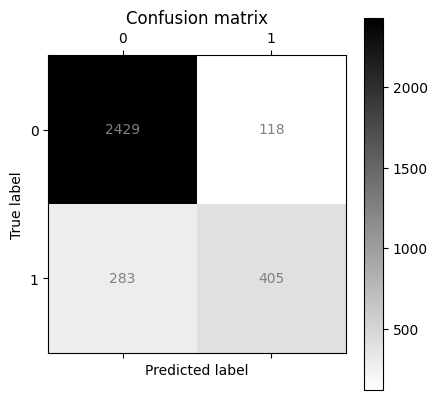

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      2547
         1.0       0.77      0.59      0.67       688

    accuracy                           0.88      3235
   macro avg       0.84      0.77      0.80      3235
weighted avg       0.87      0.88      0.87      3235



In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# save confusion matrix
cm = confusion_matrix(df["Biased"], df["Prediction_to_Boolean"])
plt.matshow(cm, cmap='binary')
plt.title('Confusion matrix')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='grey')

plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

import os
if not os.path.exists("../output/evaluation/mistral_prompt_5"):
    os.makedirs("../output/evaluation/mistral_prompt_5")
plt.savefig("../output/evaluation/mistral_prompt_5/confusion_matrix.png")

# save classification 
report = classification_report(df["Biased"], df["Prediction_to_Boolean"])
with open("../output/evaluation/mistral_prompt_5/classification_report.txt", "w") as file:
    file.write(report)

# show evaluation metrics
plt.show()
print(report)


# False Positives

Let's take a closer look at the errors.

In [49]:
mask = (df["Biased"] == 0) & (df["Prediction_to_Boolean"] == 1)
fp_df = df[mask]

pd.set_option('display.max_colwidth', None)

fp_df[["Biased", "Prediction_to_Boolean", "Text", "Prediction"]].tail()

,Biased,Prediction_to_Boolean,Text,Prediction
3161,0.0,1,"@bopanc Wow!, Merkel has let in illegals Migrants, and most are Muslims, and they want to push out Kikes!",1 The tweet is antisemitic according to the provided definition This is because it uses the term Kikes as a pejorative against Jews The tweet also contains negative stereotypes and generalizations about Muslims and immigrants further contributing to the antisemitic sentiment It demonstrates a perception of hatred toward Jews by targeting them collectively Kikes which is a clear indication of antisemitism in this context
3166,0.0,1,@Theodores_game theo-theo de cutest kikes HDHSJRS. he helps wit koko lots nd he de cutest hehe,1 The tweet in question contains several indicators of antisemitism such as using a racial slur kikes and referring to Jewish people with a derogatory term theotheo It also implies that the person being referred to Theodore is helping wit koko which seems to be an antiSemitic reference to Kabbalah or Kosher The context of the tweet and its use of derogatory language clearly indicate antisemitism so according to the definition provided I would classify this tweet as 1 antisemitic
3170,0.0,1,@MeIGibsonFan34 @vsvsq1 No kikes,1 This tweet contains an antisemitic trope by using the term kikes which is a derogatory slur targeting Jews It also demonstrates hatred towards Jews as per the definition provided Therefore this tweet qualifies as antisemitic
3171,0.0,1,"""I'm not antisemitic! That's just what the kikes want you to think!""",1 The tweet contains an antisemitic slur which is inherently hateful and aims to dehumanize or demonize Jews Its also not a selfcritique of ones own potential for holding antisemitic beliefs but rather a way of deflecting any responsibility for being potentially antisemitic So even though it does contain a claim that the author isnt antisemitic that claim is undermined by its association with a harmful slur Therefore based on your definition and context this tweet would be classified as antisemitic 1
3172,0.0,1,"@benshapiro Hey Ben, if straight dudes can call gay people Queers, can I call Jews Kikes? like it's the same thing so its ok isn't it?",1 The tweet contains a direct question that implies using antisemitic slurs is acceptable as it compares it to a term used for gay people and argues they are the same thing It seeks to normalize the use of hate speech by asking if its ok in the same context as another potentially offensive term The comparison it makes between two different communities gay people and Jews serves to further dehumanize and demonize Jewish people which falls under category 4 and 5 of the definition you provided It is therefore antisemitic based on the criteria defined


# False Negatives

In [50]:
mask = (df["Biased"] == 1) & (df["Prediction_to_Boolean"] == 0)
fn_df = df[mask]

pd.set_option('display.max_colwidth', None)

from pathlib import Path  
filepath = Path("../input/data/test_set_false_negatives.csv")

# Save annotations to csv
fn_df.to_csv(filepath)

fn_df[["Biased", "Prediction_to_Boolean", "Text", "Prediction"]].head(50)

,Biased,Prediction_to_Boolean,Text,Prediction
53,1.0,0,@LilGuillxtine @scottbix @yashar Thats Israel hating Palestine supporting money hating Jewishness for you.\nCalling him Jew is like calling Rushdie Muslim.,0 This tweet does not directly promote hatred or bigotry towards Jews or Judaism rather it criticizes the individuals it mentions for their perceived support of Israeli policies and actions It also compares Rushdie to a Jew but in this context it is used metaphorically and not as an antisemitic slur It should be noted that while some may find aspects of this tweet problematic or disagreeable it does not meet the definition of antisemitism as outlined by your given text
55,1.0,0,"@Sarah_mo7ammed1 Israel Zionists including IDF and settlers, Israeli occupying force, are state sponsored terror groups supported by American Zionist politicians who have been receiving the campaign contributions in the form of hidden bribery from AIPAC, American Israel political action committee",0 This tweet is not antisemitic according to our definition It criticizes the policies and actions of the Israeli government specifically the IDF and settlers Although it uses a strong term like state sponsored terror groups it does not target Jewish individuals or the broader Jewish community in a hateful or dehumanizing manner Instead it is critiquing specific policies and actions carried out by certain entities within Israel which while not ideal or comfortable is not inherently antisemitic It is crucial to differentiate between criticism of political entities and actions with antisemitism which targets Jewish individuals or the broader Jewish community based on their ethnicity or religion
63,1.0,0,@theshiathinker Sound like a good trade. All muslims out of Europe and into Israel. Perfect plan,0 This tweet does not contain any antisemitic tropes or language nor is it expressing hatred towards Jews While the content may be controversial the focus is on proposing a hypothetical trade involving Muslims and Israel rather than demonizing or blaming Jews or Israel for issues within society The proposal itself doesnt have an inherently antisemitic tone
78,1.0,0,Destroy every oppressor like Israel\n#Palestine\n#covid1948,The answer for this tweet is 0 it is not antisemiticnnWhile the hashtag Covid1948 can be seen as an attempt to reframe the IsraeliPalestinian conflict in terms of the Israeli declaration of independence May 14 1948 it does not contain any specific tropes or language that would classify this tweet as antisemitic The tweets primary focus is on destroying every oppressor like Israel and supporting Palestine which is more about criticizing the Israeli governments actions and policies rather than demonizing Jews or Judaism itself as per the definition of antisemitism
82,1.0,0,"What's a special relationship with Israel other than a relationship with war, racism, apartheid, surveillance, division, brutality, propaganda, lies, arrogance, disrespect, abuse, arms sales, drones, ultra right-wing politics, land theft, steel barriers and walls?",0 This tweet does not express hatred towards Jews or target individual Jewish people or institutions but rather criticizes the policies of Israel While it uses strong language to describe these issues it is not targeting Jews in general nor is it using tropes that are specifically antisemitic The author is listing several problems associated with the Israeli government and its actions which is a criticism that many people have towards specific governmental actions or political decisions in any country This tweet while expressing strong disagreement with these issues does not fall under the definition of antisemitism as it is not targeting Jews or Judaism as a whole
99,1.0,0,"@VerdiGg I,m Ex Royal Navy! I urge all men to fight for Iran if the war happens! Israel is and has been concocting a way to war with Iran .Then ask Big Stupid Brother (USA) to waste their youth for these Snakes! (Sorry Snakes!) Tics!!!",0 Wh